In [133]:
import pandas as pd
import nltk 
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import text
from matplotlib import pyplot as plt
import seaborn as sns


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evgeniy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

dataset source https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

# Feature extraction

In [4]:
train_tweets = pd.read_csv('/Users/evgeniy/Downloads/archive-3/train.csv', usecols=['label', 'tweet'])
test_tweets = pd.read_csv('/Users/evgeniy/Downloads/archive-3/test.csv')

In [5]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB


In [6]:
test_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [7]:
stop_words = set(stopwords.words('english'))

In [8]:
train_tweets.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [9]:
train_tweets['cleared_tweets'] = train_tweets['tweet'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x))

In [10]:
train_tweets['cleared_tweets'] = train_tweets['cleared_tweets'].apply(lambda x: ' '.join(x.split()))

# Classes balance

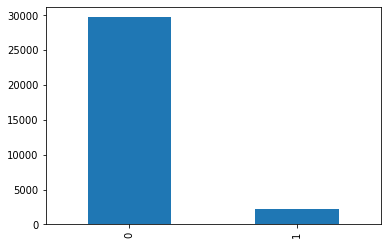

In [11]:
train_tweets['label'].value_counts().plot(kind='bar');

In [25]:
print('Minority class rate: {:.2%}'.format(
    train_tweets['label'].sum() / train_tweets.shape[0])
     )

Minority class rate: 7.01%


# Vectorizing

In [108]:
tfidf_vect = TfidfVectorizer(stop_words=stop_words, max_features=10000, ngram_range=(3, 3))
sparsed = tfidf_vect.fit_transform(train_tweets['cleared_tweets'])

tfidf = sparsed.toarray()

In [109]:
X_train, X_test, y_train, y_test = train_test_split(sparsed, 
                                                    train_tweets['label'], 
                                                    test_size=.25,
                                                    random_state=42)

# Models

## Bayes 

In [97]:
def test_model(model, X_train=X_train, X_test=X_test,
              y_train=y_train, y_test=y_test):
    model.fit(X_train, y_train)
    preds_proba = model.predict_proba(X_test)
    preds = model.predict(X_test)
    print('ROC AUC: ', roc_auc_score(y_test, preds_proba[: , 1]))
    print('Confusion matrix:')
    display(pd.DataFrame(confusion_matrix(y_test, preds)))
    fpr, tpr, _ = roc_curve(y_test, preds_proba[: , 1])
    plt.plot(fpr, tpr, label='model curve')
    plt.plot([0, 1], [0, 1], '-', label='random')
    plt.legend();

ROC AUC:  0.671023481112474
Confusion matrix:


,0,1
0,7082,350
1,382,177


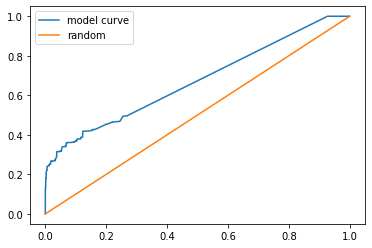

In [98]:
test_model(model)

ROC AUC:  0.7154532640363866
Confusion matrix:


,0,1
0,7432,0
1,458,101


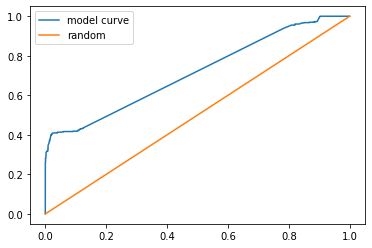

In [102]:
model = MultinomialNB()
test_model(model)

## Dense net 

In [112]:
model = Sequential()
model.add(Dense(1024, input_dim=10000, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

In [114]:
model.fit(X_train.toarray(), y_train, validation_data=(X_test.toarray(), y_test),
         epochs=5, verbose=2)

Epoch 1/5
750/750 - 52s - loss: 0.2128 - auc: 0.6980 - val_loss: 0.1817 - val_auc: 0.7620
Epoch 2/5
750/750 - 53s - loss: 0.1596 - auc: 0.8000 - val_loss: 0.1883 - val_auc: 0.7610
Epoch 3/5
750/750 - 53s - loss: 0.1545 - auc: 0.8114 - val_loss: 0.1861 - val_auc: 0.7592
Epoch 4/5
750/750 - 53s - loss: 0.1527 - auc: 0.8187 - val_loss: 0.1863 - val_auc: 0.7549
Epoch 5/5
750/750 - 53s - loss: 0.1514 - auc: 0.8160 - val_loss: 0.1934 - val_auc: 0.7566


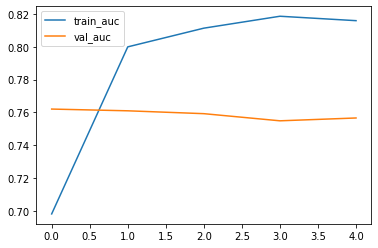

In [122]:
plt.plot(range(0, 5), model.history.history['auc'], label='train_auc')
plt.plot(range(0, 5), model.history.history['val_auc'], label='val_auc')
plt.legend();

In [124]:
model = Sequential()
model.add(Dense(1024, input_dim=10000, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

In [125]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

In [126]:
model.fit(X_train.toarray(), y_train, validation_data=(X_test.toarray(), y_test),
         epochs=5, verbose=2)

Epoch 1/5
750/750 - 54s - loss: 0.2183 - auc: 0.6824 - val_loss: 0.1818 - val_auc: 0.7655
Epoch 2/5
750/750 - 53s - loss: 0.1641 - auc: 0.7979 - val_loss: 0.1793 - val_auc: 0.7638
Epoch 3/5
750/750 - 53s - loss: 0.1567 - auc: 0.8125 - val_loss: 0.1798 - val_auc: 0.7635
Epoch 4/5
750/750 - 53s - loss: 0.1551 - auc: 0.8134 - val_loss: 0.1833 - val_auc: 0.7627
Epoch 5/5
750/750 - 53s - loss: 0.1543 - auc: 0.8111 - val_loss: 0.1846 - val_auc: 0.7623


## Embedings

In [134]:
model = Sequential()
model.add(Embedding(64, 300, input_length=10000))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

In [ ]:
model.fit(X_train.toarray(), y_train, validation_data=(X_test.toarray(), y_test),
         epochs=5, verbose=2)

Epoch 1/5
750/750 - 301s - loss: 0.3693 - auc: 0.4931 - val_loss: 0.3288 - val_auc: 0.5221
Epoch 2/5
750/750 - 290s - loss: 0.2626 - auc: 0.5208 - val_loss: 0.2495 - val_auc: 0.5413
Epoch 3/5
750/750 - 294s - loss: 0.2512 - auc: 0.5596 - val_loss: 0.2874 - val_auc: 0.5418
Epoch 4/5
